In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/수업/Info_Sys_2021/PyTorch

/content/drive/My Drive/수업/Info_Sys_2021/PyTorch


In [ ]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pylab as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [ ]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [ ]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [ ]:
class MultiLayerModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 256), nn.ReLU()) 
        self.layer2 = nn.Sequential(nn.Linear(256, 256), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.layer4 = nn.Linear(64, 10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
               
        return out

In [ ]:
class MultiLayerModel_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 256), nn.BatchNorm1d(256), nn.ReLU()) 
        self.layer2 = nn.Sequential(nn.Linear(256, 256), nn.BatchNorm1d(256), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64),nn.ReLU()) 
        self.layer4 = nn.Linear(64, 10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
               
        return out

In [ ]:
nn_model = MultiLayerModel_2().to(device)

In [ ]:
bn_model = MultiLayerModel_4().to(device)

In [ ]:
bn_model

MultiLayerModel_4(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
pip install pytorch_model_summary

In [ ]:
import pytorch_model_summary
print(pytorch_model_summary.summary(bn_model, torch.zeros(1, 28*28).to(device), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]         200,960         200,960
     BatchNorm1d-2            [1, 256]             512             512
            ReLU-3            [1, 256]               0               0
          Linear-4            [1, 256]          65,792          65,792
     BatchNorm1d-5            [1, 256]             512             512
            ReLU-6            [1, 256]               0               0
          Linear-7             [1, 64]          16,448          16,448
     BatchNorm1d-8             [1, 64]             128             128
            ReLU-9             [1, 64]               0               0
         Linear-10             [1, 10]             650             650
Total params: 285,002
Trainable params: 285,002
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [ ]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09291(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.20428(nn_acc:0.95)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.11088(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.21335(nn_acc:0.95)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.06516(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.16141(nn_acc:0.96)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.08925(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19559(nn_acc:0.96)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.05060(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.12638(nn_acc:0.97)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.07514(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14730(nn_acc:0.97)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.03894(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.17082(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.07437(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.21495(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [ ]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

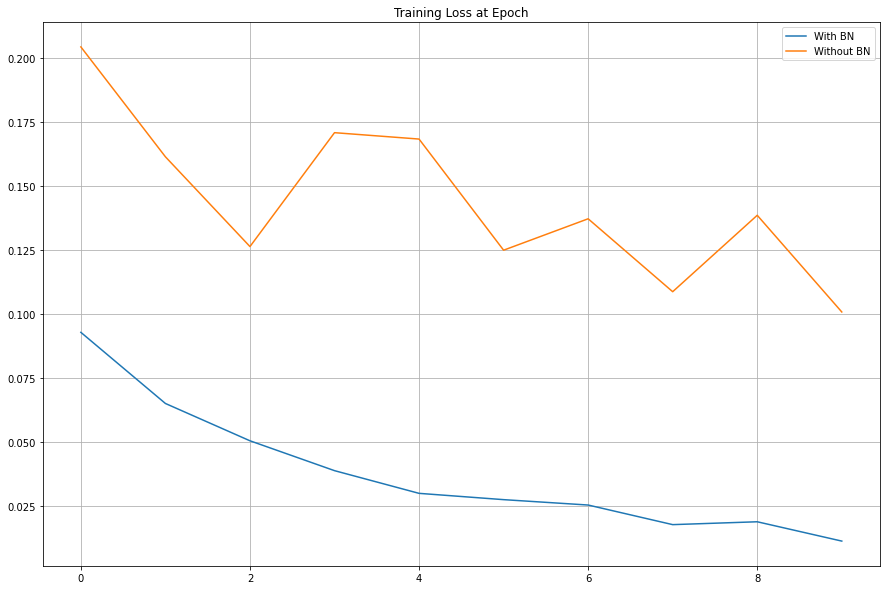

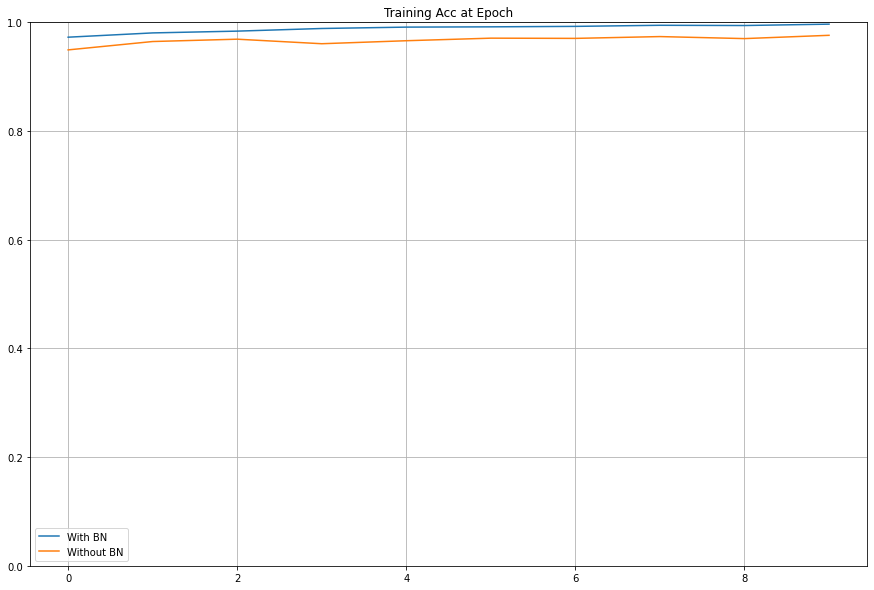

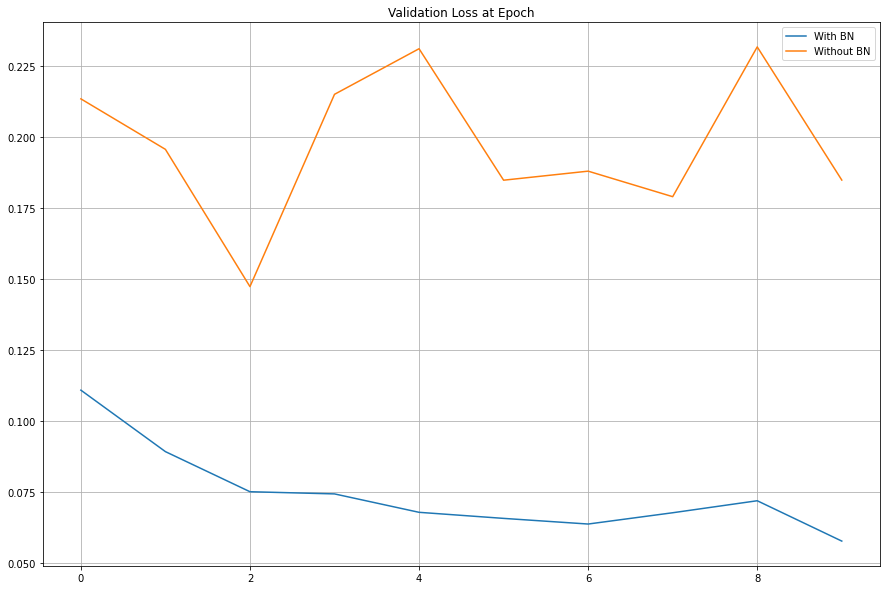

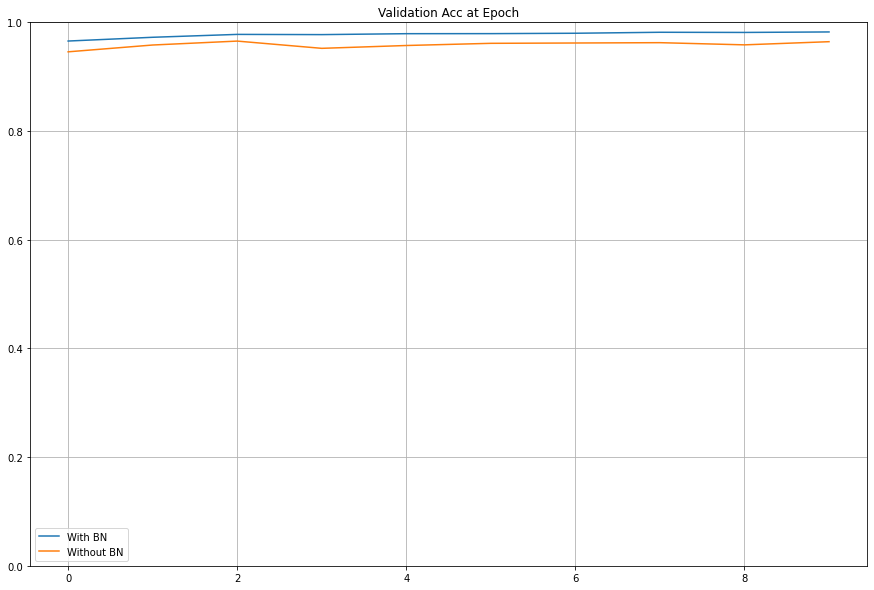

In [ ]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')